### T007_Ligand-based screening: machine learning

In [1]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

#from teachopencadd.utils import seed_everything
# Fix seed for reproducible results
SEED = 22

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Load compound and activity data

In [4]:
# Read and load data from previous talktorials
chembl_df = pd.read_csv(
    HERE / "../T000_template/data/MCL1_compounds_lipinski.csv",
    index_col=0,
)

print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()

Shape of dataframe :  (416, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4535151,0.2,nM,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.698970,"<img data-content=""rdkit/molecule"" src=""data:i...",785.322512,9,2,3.2313,True
2,CHEMBL4553660,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.698970,"<img data-content=""rdkit/molecule"" src=""data:i...",813.353812,10,2,3.4753,True
3,CHEMBL4464768,0.3,nM,CN1CC/C=C/[C@H](OCCNCC(F)(F)CO)[C@@H]2CC[C@H]2...,9.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",837.334969,10,4,3.3603,True
4,CHEMBL4446369,0.3,nM,CN1CC/C=C/[C@H](OCCN2CC(F)(F)C2)[C@@H]2CC[C@H]...,9.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",819.324404,9,2,4.0940,True
6,CHEMBL4539543,0.3,nM,COC1CN(CCO[C@H]2/C=C/CCN(C)C(=O)C[C@](O)(C(=O)...,9.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",813.353812,10,2,3.4737,True


In [5]:
# Keep only three columns: molecule_chembl_id; smiles; pIC50
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()

,molecule_chembl_id,smiles,pIC50
0,CHEMBL4535151,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.698970
2,CHEMBL4553660,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.698970
3,CHEMBL4464768,CN1CC/C=C/[C@H](OCCNCC(F)(F)CO)[C@@H]2CC[C@H]2...,9.522879
4,CHEMBL4446369,CN1CC/C=C/[C@H](OCCN2CC(F)(F)C2)[C@@H]2CC[C@H]...,9.522879
6,CHEMBL4539543,COC1CN(CCO[C@H]2/C=C/CCN(C)C(=O)C[C@](O)(C(=O)...,9.522879


### Data labeling: using the pIC50 value to classify each compound as active or inactive
### A common cut-off value to discretize pIC50 data is 6.3

In [7]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

chembl_df.head()

Number of active compounds: 84
Number of inactive compounds: 332


,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL4535151,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.698970,1.0
2,CHEMBL4553660,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.698970,1.0
3,CHEMBL4464768,CN1CC/C=C/[C@H](OCCNCC(F)(F)CO)[C@@H]2CC[C@H]2...,9.522879,1.0
4,CHEMBL4446369,CN1CC/C=C/[C@H](OCCN2CC(F)(F)C2)[C@@H]2CC[C@H]...,9.522879,1.0
6,CHEMBL4539543,COC1CN(CCO[C@H]2/C=C/CCN(C)C(=O)C[C@](O)(C(=O)...,9.522879,1.0


### Molecue encoding (define a function smiles_to_fp to generate fingerprints from SMILES)

In [9]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [11]:
# Add column for fingerprint
compound_df = chembl_df.copy()
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL4535151,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.698970,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,CHEMBL4553660,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.698970,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,CHEMBL4464768,CN1CC/C=C/[C@H](OCCNCC(F)(F)CO)[C@@H]2CC[C@H]2...,9.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


### Try several ML approaches（RF，SVM，ANN） to classify our molecules

In [ ]:
### Define a function "model_training_and_validation" which fits a model on a random train-test split of the data and returns measures such as accuracy, sensitivity, specificity and AUC evaluated on the test set

In [14]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

### Define a function “model_performance” to plot the ROC curves (calculate model performance)

In [16]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

### Define a function "model_training_and_validation" to fit a machine learning model on a random train-test split of the data and return the performance

In [18]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

### Preprocessing: Split the data (will be reused for the other models)

In [20]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2)#, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 332
Test data size: 84


In [21]:
### Random forest

In [22]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [23]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.56
Specificity: 0.97
AUC: 0.93


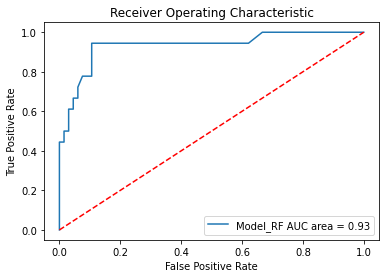

In [24]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [25]:
### Support vector machines

In [26]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.56
Specificity: 0.94
AUC: 0.92


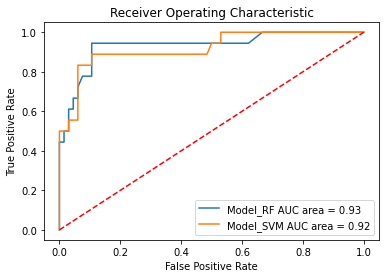

In [27]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [28]:
### Artificial neural networks

In [29]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3))#, random_state)=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.61
Specificity: 0.97
AUC: 0.92


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


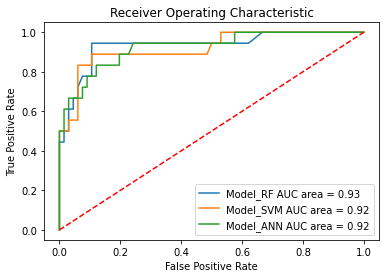

In [30]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

In [31]:
### Cross-validation

In [32]:
### Define a function "crossvalidation" to  perform cross-validation experiments with the three different models

In [33]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True)#, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [34]:
### Perform cross validation

In [35]:
N_FOLDS = 3

for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.92 	and std : 0.03 
Mean sensitivity: 0.74 	and std : 0.09 
Mean specificity: 0.97 	and std : 0.02 
Mean AUC: 0.93 	and std : 0.03 
Time taken : 0.63s


Model_SVM
Mean accuracy: 0.92 	and std : 0.04 
Mean sensitivity: 0.66 	and std : 0.13 
Mean specificity: 0.99 	and std : 0.00 
Mean AUC: 0.93 	and std : 0.02 
Time taken : 0.24s


Model_ANN


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean accuracy: 0.87 	and std : 0.04 
Mean sensitivity: 0.40 	and std : 0.29 
Mean specificity: 0.98 	and std : 0.01 
Mean AUC: 0.93 	and std : 0.00 
Time taken : 0.91s



/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [36]:
### Look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys

In [37]:
# Reset data frame
compound_df = chembl_df.copy()

# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)

for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.91 	and std : 0.03 
Mean sensitivity: 0.68 	and std : 0.12 
Mean specificity: 0.97 	and std : 0.01 
Mean AUC: 0.92 	and std : 0.01 
Time taken : 0.83s


Model_ANN


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean accuracy: 0.94 	and std : 0.02 
Mean sensitivity: 0.77 	and std : 0.16 
Mean specificity: 0.98 	and std : 0.01 
Mean AUC: 0.95 	and std : 0.03 
Time taken : 10.70s



/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
